# 01__rna_seq_analysis

in this notebook, i look at lncRNA + mRNA expression across the 3 lineages from our RNA-seq data. note that in our RNA-seq data, we use GENCODE v25 (mapped to hg19) as the transcriptome assembly.

figures in this notebook:
- Fig 2A: heatmap of expression across samples for lncRNAs and mRNAs
- Fig 2B: expression of marker genes across lineages
- Fig 2C: GO term enrichments
- Fig 2D: count of expressed lncRNAs by biotype
- Fig 2E: volcano plots of lncRNA expression in endo and meso compared to hESCs
- Fig 2F: tissue-specificity of lncRNAs compared to all mRNAs and only transcription factors
- Fig S3A: heatmap showing correlation of abundances across RNA-seq samples
- Fig S3B: overview of expression profiles for lncRNAs

supplemental tables in this notebook:
- Supp Table S1: RNA-seq results for lncRNAs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gseapy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

### functions

In [3]:
def is_significant(row, colname, alpha):
    qval = row[colname]
    if qval == "sleuth NA":
        return qval
    else:
        if qval < alpha:
            return "significant"
        else:
            return "not significant"

In [4]:
def mark_for_volcano(row, exp_col, sig_col):
    log2fc = row[exp_col]
    sig = row[sig_col]
    if sig == "significant":
        return "significant"
    else:
        return "not significant"

### variables

In [5]:
sleuth_dir = "../../data/00__rna_seq/00__sleuth_results"

In [6]:
expr_f = "%s/sleuth_abundances_norm_tpm.TRANSCRIPTS.txt" % (sleuth_dir)
diff_hESC_endo_f = "%s/diff_hESC_vs_endo.TRANSCRIPTS.txt" % (sleuth_dir)
diff_hESC_meso_f = "%s/diff_hESC_vs_meso.TRANSCRIPTS.txt" % (sleuth_dir)

In [7]:
lncRNA_gene_biotype_map_f = "../../misc/00__gene_metadata/all_lncRNAs_classified.locus.buffer.with_name.txt"
lncRNA_tx_biotype_map_f = "../../misc/00__gene_metadata/all_lncRNAs_classified.txt"
all_biotype_map_f = "../../misc/00__gene_metadata/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
transcript_id_map_f = "../../misc/00__gene_metadata/gencode.v25lift37.GENE_ID_TRANSCRIPT_ID_MAP.with_DIGIT.fixed.txt"

In [8]:
tfs_f = "../../misc/01__curated_TF_list/curated_motif_map.txt"

### 1. import data

In [9]:
expr = pd.read_table(expr_f, sep="\t").reset_index()
expr.columns = ["transcript_id", "endo_rep1", "endo_rep2", "hESC_rep1", "hESC_rep2", "meso_rep1", "meso_rep2"]

In [10]:
expr.head()

transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2  
0    0.000000    0.014741  
1  163.429313  245.318970  
2   30.153659   10.951882  
3    7.430429    7.769760  
4   55.957769   68.012268

In [11]:
transcript_id_map = pd.read_table(transcript_id_map_f, sep="\t", header=None)
transcript_id_map.columns = ["gene_id", "transcript_id"]
transcript_id_map.head()

gene_id        transcript_id
0  ENSG00000223972.5_1  ENST00000456328.2_1
1  ENSG00000223972.5_1  ENST00000450305.2_1
2  ENSG00000227232.5_1  ENST00000488147.1_1
3  ENSG00000243485.4_2  ENST00000473358.1_1
4  ENSG00000243485.4_2  ENST00000469289.1_1

In [12]:
print(len(expr))
expr = expr.merge(transcript_id_map, on="transcript_id")
print(len(expr))
expr.head()

200140
200140


transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2               gene_id  
0    0.000000    0.014741                 DIGIT  
1  163.429313  245.318970  ENSG00000004059.10_2  
2   30.153659   10.951882     ENSG00000003056.3  
3    7.430429    7.769760  ENSG00000173153.13_2  
4   55.957769   68.012268   ENSG00000004478.7_1

In [13]:
# annotation biotypes
ann_biotype_map = pd.read_table(all_biotype_map_f, sep="\t", header=None)
ann_biotype_map.columns = ["gene_id", "biotype", "gene_name"]
ann_biotype_map.head()

gene_id                             biotype  gene_name
0  ENSG00000223972.5_1  transcribed_unprocessed_pseudogene    DDX11L1
1  ENSG00000227232.5_1              unprocessed_pseudogene     WASH7P
2  ENSG00000243485.4_2                             lincRNA  MIR1302-2
3  ENSG00000237613.2_1                             lincRNA    FAM138A
4  ENSG00000268020.3_1              unprocessed_pseudogene     OR4G4P

In [14]:
# find transcript-level biotype
lncRNA_tx_biotype_map = pd.read_table(lncRNA_tx_biotype_map_f, sep="\t", header=None)
lncRNA_tx_biotype_map.columns = ["transcript_id", "csf_class", "biotype"]
lncRNA_tx_biotype_map.head()

transcript_id        csf_class  \
0  ENST00000229465.10_1  lncRNA_good_csf   
1   ENST00000230113.4_1  lncRNA_good_csf   
2   ENST00000235290.7_1  lncRNA_good_csf   
3   ENST00000242109.5_1  lncRNA_good_csf   
4   ENST00000244820.2_1  lncRNA_good_csf   

                                             biotype  
0  antisense__lncRNA,divergent__lncRNA,gene_upstr...  
1                                         intergenic  
2  divergent__protein_coding,gene_upstream__prote...  
3          antisense__lncRNA,tss_overlapping__lncRNA  
4                                         intergenic

In [15]:
# find gene-level biotype
lncRNA_gene_biotype_map = pd.read_table(lncRNA_gene_biotype_map_f, sep="\t", header=None)
lncRNA_gene_biotype_map.columns = ["gene_name", "gene_id", "csf_class", "gene_biotype", "cage_peak", "strand"]
lncRNA_gene_biotype_map.head()

gene_name               gene_id        csf_class  \
0           SPPL2B    ENSG00000005206.12  lncRNA_good_csf   
1        LINC01587   ENSG00000082929.8_1  lncRNA_good_csf   
2       AC000111.6   ENSG00000083622.8_1  lncRNA_good_csf   
3  XXbac-B461K10.4  ENSG00000093100.13_2   lncRNA_bad_csf   
4          IGF2-AS   ENSG00000099869.7_1  lncRNA_good_csf   

                                        gene_biotype  \
0  antisense__lncRNA,antisense__protein_coding,se...   
1                                         intergenic   
2                          antisense__protein_coding   
3                  sense_overlapping__protein_coding   
4  antisense__protein_coding,tss_overlapping__pro...   

                  cage_peak strand  
0     chr19:2327613-2356099      +  
1      chr4:5525295-5530528      +  
2  chr7:117243844-117288469      -  
3   chr22:18269417-18295263      -  
4     chr11:2160730-2170896      +

### merge all biotype information (transcript level, gene level) and fix DIGIT which was added manually

In [16]:
# merge everything
expr_tmp = expr.merge(ann_biotype_map, on="gene_id", how="left", suffixes=("", "_ann"))
expr_tmp = expr_tmp.merge(lncRNA_tx_biotype_map, on="transcript_id", suffixes=("", "_lncRNA"), how="left")
expr_tmp = expr_tmp.merge(lncRNA_gene_biotype_map[["gene_id", "gene_biotype"]], on="gene_id", how="left")
expr_tmp.head()

transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2               gene_id         biotype gene_name  \
0    0.000000    0.014741                 DIGIT             NaN       NaN   
1  163.429313  245.318970  ENSG00000004059.10_2  protein_coding      ARF5   
2   30.153659   10.951882     ENSG00000003056.3  protein_coding      M6PR   
3    7.430429    7.769760  ENSG00000173153.13_2  protein_coding     ESRRA   
4   55.957769   68.012268   ENSG00000004478.7_1  protein_coding     FKBP4   

  csf_class biotype_lncRNA gene_biotype  
0       NaN            NaN          NaN  
1       NaN            NaN          NaN  
2       NaN            NaN          NaN  
3       NaN            NaN          NaN  
4       NaN            NaN          NaN

In [17]:
# fix digit
expr_tmp.loc[0, "biotype"] = "tss_overlapping__lncRNA"
expr_tmp.loc[0, "gene_name"] = "DIGIT"
expr_tmp.loc[0, "csf_class"] = "lncRNA_good_csf"
expr_tmp.loc[0, "biotype_lncRNA"] = "tss_overlapping__lncRNA"
expr_tmp.loc[0, "gene_biotype"] = "tss_overlapping__lncRNA"
expr_tmp.head()

transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2               gene_id                  biotype  \
0    0.000000    0.014741                 DIGIT  tss_overlapping__lncRNA   
1  163.429313  245.318970  ENSG00000004059.10_2           protein_coding   
2   30.153659   10.951882     ENSG00000003056.3           protein_coding   
3    7.430429    7.769760  ENSG00000173153.13_2           protein_coding   
4   55.957769   68.012268   ENSG00000004478.7_1           protein_coding   

  gene_name        csf_class           biotype_lncRNA             gene_biotype  
0     DIGIT  lncRNA_good_csf  tss_overlapping__lncRNA  tss_overlapping__lncRNA  
1      ARF5              NaN                      NaN                      NaN  
2      M6PR              NaN                      NaN                      NaN  
3     ESRRA              NaN                      NaN                      NaN  
4     FKBP4              NaN                      NaN                      NaN

In [18]:
expr_tmp["csf"] = expr_tmp.apply(get_csf_class, axis=1)
expr_tmp.head()

transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2               gene_id                  biotype  \
0    0.000000    0.014741                 DIGIT  tss_overlapping__lncRNA   
1  163.429313  245.318970  ENSG00000004059.10_2           protein_coding   
2   30.153659   10.951882     ENSG00000003056.3           protein_coding   
3    7.430429    7.769760  ENSG00000173153.13_2           protein_coding   
4   55.957769   68.012268   ENSG00000004478.7_1           protein_coding   

  gene_name        csf_class           biotype_lncRNA  \
0     DIGIT  lncRNA_good_csf  tss_overlapping__lncRNA   
1      ARF5              NaN                      NaN   
2      M6PR              NaN                      NaN   
3     ESRRA              NaN                      NaN   
4     FKBP4              NaN                      NaN   

              gene_biotype              csf  
0  tss_overlapping__lncRNA  lncRNA_good_csf  
1                      NaN   protein_coding  
2                      NaN   protein_coding  
3                      NaN   protein_coding  
4                      NaN   protein_coding

In [19]:
expr_tmp["transcript_biotype"] = expr_tmp.apply(get_transcript_biotype, axis=1)

In [20]:
expr_tmp["gene_biotype"] = expr_tmp.apply(get_gene_biotype, axis=1)

In [21]:
expr_tmp.head()

transcript_id   endo_rep1   endo_rep2   hESC_rep1   hESC_rep2  \
0                 DIGIT    4.907468    4.784695    0.000000    0.025422   
1   ENST00000000233.9_1  222.677573  197.586091  101.476958  102.386195   
2     ENST00000000412.3   31.608496   36.350968   49.696030   46.457026   
3  ENST00000000442.10_1    3.499700    2.419880    1.924618    3.493033   
4   ENST00000001008.5_1   33.770398   33.810736   71.840722   79.489420   

    meso_rep1   meso_rep2               gene_id                  biotype  \
0    0.000000    0.014741                 DIGIT  tss_overlapping__lncRNA   
1  163.429313  245.318970  ENSG00000004059.10_2           protein_coding   
2   30.153659   10.951882     ENSG00000003056.3           protein_coding   
3    7.430429    7.769760  ENSG00000173153.13_2           protein_coding   
4   55.957769   68.012268   ENSG00000004478.7_1           protein_coding   

  gene_name        csf_class           biotype_lncRNA  \
0     DIGIT  lncRNA_good_csf  tss_overlapping__lncRNA   
1      ARF5              NaN                      NaN   
2      M6PR              NaN                      NaN   
3     ESRRA              NaN                      NaN   
4     FKBP4              NaN                      NaN   

              gene_biotype              csf       transcript_biotype  
0  tss_overlapping__lncRNA  lncRNA_good_csf  tss_overlapping__lncRNA  
1           protein_coding   protein_coding           protein_coding  
2           protein_coding   protein_coding           protein_coding  
3           protein_coding   protein_coding           protein_coding  
4           protein_coding   protein_coding           protein_coding

In [22]:
expr = expr_tmp[["transcript_id", "gene_id", "gene_name", "csf", "transcript_biotype", "gene_biotype",
                 "hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]].drop_duplicates()

In [23]:
len(expr)

200140

### 2. find mean expression per gene across condition

throughout this notebook, the 'expr' df has transcript values, whereas the 'expr_gene' df has gene values (summed transcript values)

In [24]:
# also get gene expression values, not transcript expression values (for plotting)
expr_gene = expr.groupby(["gene_id", "gene_name", "csf", "gene_biotype"])[["hESC_rep1", "hESC_rep2", "endo_rep1", 
                                                                           "endo_rep2", "meso_rep1", "meso_rep2"]].agg("sum").reset_index()
print(len(expr_gene))
expr_gene.head()

60253


gene_id gene_name              csf             gene_biotype  \
0                 DIGIT     DIGIT  lncRNA_good_csf  tss_overlapping__lncRNA   
1  ENSG00000000003.14_1    TSPAN6   protein_coding           protein_coding   
2   ENSG00000000005.5_1      TNMD   protein_coding           protein_coding   
3  ENSG00000000419.12_1      DPM1   protein_coding           protein_coding   
4  ENSG00000000457.13_1     SCYL3   protein_coding           protein_coding   

   hESC_rep1  hESC_rep2  endo_rep1  endo_rep2  meso_rep1  meso_rep2  
0   0.000000   0.025422   4.907468   4.784695   0.000000   0.014741  
1  58.565196  56.853744  45.878426  48.621591  72.147888  71.335968  
2   1.065436   1.873722   0.014256   0.086040   0.524347   0.733716  
3  91.614314  89.531169  74.968409  74.861973  85.464782  78.192502  
4   3.625205   3.752247   3.958917   4.453596   3.679235   2.713760

In [25]:
expr["hESC_mean"] = expr[["hESC_rep1", "hESC_rep2"]].mean(axis=1)
expr["hESC_std"] = expr[["hESC_rep1", "hESC_rep2"]].std(axis=1)

expr["endo_mean"] = expr[["endo_rep1", "endo_rep2"]].mean(axis=1)
expr["endo_std"] = expr[["endo_rep1", "endo_rep2"]].std(axis=1)

expr["meso_mean"] = expr[["meso_rep1", "meso_rep2"]].mean(axis=1)
expr["meso_std"] = expr[["meso_rep1", "meso_rep2"]].std(axis=1)

expr["overall_mean"] = expr[["hESC_mean", "endo_mean", "meso_mean"]].mean(axis=1)
expr.head()

transcript_id               gene_id gene_name              csf  \
0                 DIGIT                 DIGIT     DIGIT  lncRNA_good_csf   
1   ENST00000000233.9_1  ENSG00000004059.10_2      ARF5   protein_coding   
2     ENST00000000412.3     ENSG00000003056.3      M6PR   protein_coding   
3  ENST00000000442.10_1  ENSG00000173153.13_2     ESRRA   protein_coding   
4   ENST00000001008.5_1   ENSG00000004478.7_1     FKBP4   protein_coding   

        transcript_biotype             gene_biotype   hESC_rep1   hESC_rep2  \
0  tss_overlapping__lncRNA  tss_overlapping__lncRNA    0.000000    0.025422   
1           protein_coding           protein_coding  101.476958  102.386195   
2           protein_coding           protein_coding   49.696030   46.457026   
3           protein_coding           protein_coding    1.924618    3.493033   
4           protein_coding           protein_coding   71.840722   79.489420   

    endo_rep1   endo_rep2   meso_rep1   meso_rep2   hESC_mean  hESC_std  \
0    4.907468    4.784695    0.000000    0.014741    0.012711  0.017976   
1  222.677573  197.586091  163.429313  245.318970  101.931577  0.642927   
2   31.608496   36.350968   30.153659   10.951882   48.076528  2.290321   
3    3.499700    2.419880    7.430429    7.769760    2.708826  1.109037   
4   33.770398   33.810736   55.957769   68.012268   75.665071  5.408446   

    endo_mean   endo_std   meso_mean   meso_std  overall_mean  
0    4.846082   0.086813    0.007370   0.010423      1.622054  
1  210.131832  17.742357  204.374142  57.904732    172.145850  
2   33.979732   3.353434   20.552771  13.577707     34.203010  
3    2.959790   0.763548    7.600094   0.239943      4.422903  
4   33.790567   0.028524   61.985019   8.523818     57.146886

In [26]:
expr_gene["hESC_mean"] = expr_gene[["hESC_rep1", "hESC_rep2"]].mean(axis=1)
expr_gene["hESC_std"] = expr_gene[["hESC_rep1", "hESC_rep2"]].std(axis=1)

expr_gene["endo_mean"] = expr_gene[["endo_rep1", "endo_rep2"]].mean(axis=1)
expr_gene["endo_std"] = expr_gene[["endo_rep1", "endo_rep2"]].std(axis=1)

expr_gene["meso_mean"] = expr_gene[["meso_rep1", "meso_rep2"]].mean(axis=1)
expr_gene["meso_std"] = expr_gene[["meso_rep1", "meso_rep2"]].std(axis=1)

expr_gene["overall_mean"] = expr_gene[["hESC_mean", "endo_mean", "meso_mean"]].mean(axis=1)
expr_gene.head()

gene_id gene_name              csf             gene_biotype  \
0                 DIGIT     DIGIT  lncRNA_good_csf  tss_overlapping__lncRNA   
1  ENSG00000000003.14_1    TSPAN6   protein_coding           protein_coding   
2   ENSG00000000005.5_1      TNMD   protein_coding           protein_coding   
3  ENSG00000000419.12_1      DPM1   protein_coding           protein_coding   
4  ENSG00000000457.13_1     SCYL3   protein_coding           protein_coding   

   hESC_rep1  hESC_rep2  endo_rep1  endo_rep2  meso_rep1  meso_rep2  \
0   0.000000   0.025422   4.907468   4.784695   0.000000   0.014741   
1  58.565196  56.853744  45.878426  48.621591  72.147888  71.335968   
2   1.065436   1.873722   0.014256   0.086040   0.524347   0.733716   
3  91.614314  89.531169  74.968409  74.861973  85.464782  78.192502   
4   3.625205   3.752247   3.958917   4.453596   3.679235   2.713760   

   hESC_mean  hESC_std  endo_mean  endo_std  meso_mean  meso_std  overall_mean  
0   0.012711  0.017976   4.846082  0.086813   0.007370  0.010423      1.622054  
1  57.709470  1.210179  47.250008  1.939710  71.741928  0.574114     58.900469  
2   1.469579  0.571545   0.050148  0.050758   0.629031  0.148046      0.716253  
3  90.572742  1.473006  74.915191  0.075262  81.828642  5.142279     82.438858  
4   3.688726  0.089832   4.206257  0.349791   3.196498  0.682694      3.697160

### 3. find transcripts & genes expressed at least at 0.1 tpm (in at least 1 condition)

In [27]:
expr["threshold"] = expr.apply(get_expr_thresh, axis=1)
expr_gene["threshold"] = expr_gene.apply(get_expr_thresh, axis=1)
expr.head()

transcript_id               gene_id gene_name              csf  \
0                 DIGIT                 DIGIT     DIGIT  lncRNA_good_csf   
1   ENST00000000233.9_1  ENSG00000004059.10_2      ARF5   protein_coding   
2     ENST00000000412.3     ENSG00000003056.3      M6PR   protein_coding   
3  ENST00000000442.10_1  ENSG00000173153.13_2     ESRRA   protein_coding   
4   ENST00000001008.5_1   ENSG00000004478.7_1     FKBP4   protein_coding   

        transcript_biotype             gene_biotype   hESC_rep1   hESC_rep2  \
0  tss_overlapping__lncRNA  tss_overlapping__lncRNA    0.000000    0.025422   
1           protein_coding           protein_coding  101.476958  102.386195   
2           protein_coding           protein_coding   49.696030   46.457026   
3           protein_coding           protein_coding    1.924618    3.493033   
4           protein_coding           protein_coding   71.840722   79.489420   

    endo_rep1   endo_rep2   meso_rep1   meso_rep2   hESC_mean  hESC_std  \
0    4.907468    4.784695    0.000000    0.014741    0.012711  0.017976   
1  222.677573  197.586091  163.429313  245.318970  101.931577  0.642927   
2   31.608496   36.350968   30.153659   10.951882   48.076528  2.290321   
3    3.499700    2.419880    7.430429    7.769760    2.708826  1.109037   
4   33.770398   33.810736   55.957769   68.012268   75.665071  5.408446   

    endo_mean   endo_std   meso_mean   meso_std  overall_mean  threshold  
0    4.846082   0.086813    0.007370   0.010423      1.622054  expressed  
1  210.131832  17.742357  204.374142  57.904732    172.145850  expressed  
2   33.979732   3.353434   20.552771  13.577707     34.203010  expressed  
3    2.959790   0.763548    7.600094   0.239943      4.422903  expressed  
4   33.790567   0.028524   61.985019   8.523818     57.146886  expressed

In [28]:
expr.groupby(["csf", "threshold"])["transcript_id"].agg("count")

csf              threshold    
lncRNA_bad_csf   expressed          1451
                 not expressed       931
lncRNA_good_csf  expressed         12713
                 not expressed     12549
protein_coding   expressed        102773
                 not expressed     42743
unclear          expressed         10140
                 not expressed     16840
Name: transcript_id, dtype: int64

In [29]:
expr_gene.groupby(["csf", "threshold"])["gene_id"].agg("count")

csf              threshold    
lncRNA_bad_csf   expressed         1286
                 not expressed      736
lncRNA_good_csf  expressed         8261
                 not expressed     5566
protein_coding   expressed        17332
                 not expressed     2800
unclear          expressed         8945
                 not expressed    15327
Name: gene_id, dtype: int64

In [30]:
expr["clean_gene_biotype"] = expr.apply(clean_biotype, col="gene_biotype", axis=1)
expr["clean_transcript_biotype"] = expr.apply(clean_biotype, col="transcript_biotype", axis=1)
expr_gene["clean_gene_biotype"] = expr_gene.apply(clean_biotype, col="gene_biotype", axis=1)

### 4. filter on good biotypes

for now, keep all biotypes, but note if biotypes include tss_overlapping or divergent

In [31]:
expr["cleaner_gene_biotype"] = expr.apply(cleaner_biotype, col="gene_biotype", axis=1)
expr["cleaner_transcript_biotype"] = expr.apply(cleaner_biotype, col="transcript_biotype", axis=1)

In [32]:
expr_gene["cleaner_biotype"] = expr_gene.apply(cleaner_biotype, col="gene_biotype", axis=1)

In [33]:
bad_biotypes = ["biotype not considered"]
bad_csf = ["lncRNA_bad_csf"]
expr_filt = expr[~expr["cleaner_gene_biotype"].isin(bad_biotypes)]
expr_filt = expr_filt[~expr_filt["csf"].isin(bad_csf)]

In [34]:
expr_gene_filt = expr_gene[~expr_gene["cleaner_biotype"].isin(bad_biotypes)]
expr_gene_filt = expr_gene_filt[~expr_gene_filt["csf"].isin(bad_csf)]

In [35]:
order = ["protein_coding", "intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby"]
pal = {"protein_coding": sns.color_palette("deep")[0], "intergenic": "firebrick", "promoter_overlap": "firebrick",
       "transcript_overlap": "firebrick", "gene_nearby": "firebrick"}

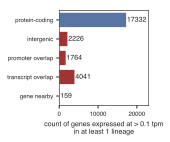

In [36]:
plt.figure(figsize=(1.6,1.75))
ax = sns.countplot(y="cleaner_biotype", data=expr_gene_filt[expr_gene_filt["threshold"] == "expressed"], 
                   palette=pal, order=order)

for p in ax.patches:
    w = p.get_width()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(w + 100, y + h/2, int(w), ha="left", va="center", fontsize=fontsize) 

plt.xlim((0,23000))
plt.legend(loc=4)
plt.xlabel("count of genes expressed at > 0.1 tpm\nin at least 1 lineage")
plt.ylabel("")
ax.set_yticklabels(["protein-coding", "intergenic", "promoter overlap", "transcript overlap", "gene nearby"])
plt.savefig("Fig2D.pdf", dpi="figure", bbox_inches="tight")

In [37]:
expr_filt["coding_type"] = expr_filt.apply(coding_type, axis=1)
expr_gene_filt["coding_type"] = expr_gene_filt.apply(coding_type, axis=1)

In [38]:
expr_filt["hESC_thresh"] = expr_filt.apply(hESC_thresh, axis=1)
expr_filt["endo_thresh"] = expr_filt.apply(endo_thresh, axis=1)
expr_filt["meso_thresh"] = expr_filt.apply(meso_thresh, axis=1)
expr_filt.head()

transcript_id               gene_id gene_name              csf  \
0                 DIGIT                 DIGIT     DIGIT  lncRNA_good_csf   
1   ENST00000000233.9_1  ENSG00000004059.10_2      ARF5   protein_coding   
2     ENST00000000412.3     ENSG00000003056.3      M6PR   protein_coding   
3  ENST00000000442.10_1  ENSG00000173153.13_2     ESRRA   protein_coding   
4   ENST00000001008.5_1   ENSG00000004478.7_1     FKBP4   protein_coding   

        transcript_biotype             gene_biotype   hESC_rep1   hESC_rep2  \
0  tss_overlapping__lncRNA  tss_overlapping__lncRNA    0.000000    0.025422   
1           protein_coding           protein_coding  101.476958  102.386195   
2           protein_coding           protein_coding   49.696030   46.457026   
3           protein_coding           protein_coding    1.924618    3.493033   
4           protein_coding           protein_coding   71.840722   79.489420   

    endo_rep1   endo_rep2      ...        overall_mean  threshold  \
0    4.907468    4.784695      ...            1.622054  expressed   
1  222.677573  197.586091      ...          172.145850  expressed   
2   31.608496   36.350968      ...           34.203010  expressed   
3    3.499700    2.419880      ...            4.422903  expressed   
4   33.770398   33.810736      ...           57.146886  expressed   

        clean_gene_biotype  clean_transcript_biotype  cleaner_gene_biotype  \
0  tss_overlapping__lncRNA   tss_overlapping__lncRNA      promoter_overlap   
1           protein_coding            protein_coding        protein_coding   
2           protein_coding            protein_coding        protein_coding   
3           protein_coding            protein_coding        protein_coding   
4           protein_coding            protein_coding        protein_coding   

   cleaner_transcript_biotype  coding_type    hESC_thresh  endo_thresh  \
0            promoter_overlap   non-coding  not expressed    expressed   
1              protein_coding       coding      expressed    expressed   
2              protein_coding       coding      expressed    expressed   
3              protein_coding       coding      expressed    expressed   
4              protein_coding       coding      expressed    expressed   

     meso_thresh  
0  not expressed  
1      expressed  
2      expressed  
3      expressed  
4      expressed  

[5 rows x 28 columns]

In [39]:
expr_gene_filt["hESC_thresh"] = expr_gene_filt.apply(hESC_thresh, axis=1)
expr_gene_filt["endo_thresh"] = expr_gene_filt.apply(endo_thresh, axis=1)
expr_gene_filt["meso_thresh"] = expr_gene_filt.apply(meso_thresh, axis=1)

In [40]:
hESC_nc = set(expr_filt[(expr_filt["hESC_thresh"] == "expressed") & (expr_filt["coding_type"] == "non-coding")]["gene_name"])
endo_nc = set(expr_filt[(expr_filt["endo_thresh"] == "expressed") & (expr_filt["coding_type"] == "non-coding")]["gene_name"])
meso_nc = set(expr_filt[(expr_filt["meso_thresh"] == "expressed") & (expr_filt["coding_type"] == "non-coding")]["gene_name"])

all_nc = set.intersection(hESC_nc, endo_nc, meso_nc)
print("there are %s lncRNAs expressed in all lineages" % (len(all_nc)))

hESC_endo_nc = set.intersection(hESC_nc, endo_nc)
print("there are %s lncRNAs expressed in hESC and endo lineages" % (len(hESC_endo_nc)))

hESC_meso_nc = set.intersection(hESC_nc, meso_nc)
print("there are %s lncRNAs expressed in hESC and meso lineages" % (len(hESC_meso_nc)))

endo_meso_nc = set.intersection(endo_nc, meso_nc)
print("there are %s lncRNAs expressed in endo and meso lineages" % (len(endo_meso_nc)))

there are 4396 lncRNAs expressed in all lineages
there are 5327 lncRNAs expressed in hESC and endo lineages
there are 4760 lncRNAs expressed in hESC and meso lineages
there are 4783 lncRNAs expressed in endo and meso lineages


In [41]:
expr_ncRNA_filt = expr_filt[expr_filt["coding_type"] == "non-coding"]
expr_ncRNA_filt["expr_profile"] = expr_ncRNA_filt.apply(get_expr_profile, axis=1)

In [42]:
len(expr_ncRNA_filt[expr_ncRNA_filt["expr_profile"] != "not expressed"])

12611

In [43]:
# check for size of libraries right now
expr_ncRNA_gene_filt = expr_gene_filt[expr_gene_filt["coding_type"] == "non-coding"]
expr_ncRNA_gene_filt["expr_profile"] = expr_ncRNA_gene_filt.apply(get_expr_profile, axis=1)

In [44]:
len(expr_ncRNA_gene_filt)

13724

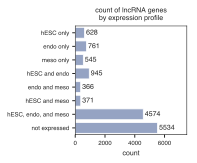

In [45]:
fig = plt.figure(figsize=(2,2))
ax = sns.countplot(y="expr_profile", data=expr_ncRNA_gene_filt,
                   order=["hESC only", "endo only", "meso only", "hESC and endo", "endo and meso", "hESC and meso",
                          "hESC, endo, and meso", "not expressed"], color=sns.color_palette("Set2")[2])

for p in ax.patches:
    w = p.get_width()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(w + 100, y + h/2, int(w), ha="left", va="center", fontsize=fontsize) 

plt.xlim((0,7500))
plt.title("count of lncRNA genes\nby expression profile")
plt.ylabel("")
fig.savefig("FigS3B.pdf", bbox_inches="tight", dpi="figure")

### 5. check correlations between replicates

In [46]:
expr_reps = expr[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
expr_reps_corr = expr_reps.corr(method="spearman")

In [47]:
# cg = sns.clustermap(expr_reps_corr, annot=True, vmin=0.7, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(2.25,2.25))
# plt.suptitle("spearman correlation of replicates (all transcript tpms, not filtered)")
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.savefig("replicate_corrs_spearman.pdf", bbox_inches="tight", dpi="figure")

In [48]:
expr_gene_reps = expr_gene[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
expr_gene_reps_corr = expr_gene_reps.corr(method="spearman")

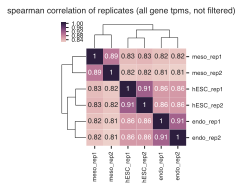

In [49]:
cg = sns.clustermap(expr_gene_reps_corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(2.25,2.25))
plt.suptitle("spearman correlation of replicates (all gene tpms, not filtered)")
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig("FigS3A.pdf", bbox_inches="tight", dpi="figure")

In [50]:
expr_thresh = expr[expr["threshold"] == "expressed"]
expr_gene_thresh = expr_gene[expr_gene["threshold"] == "expressed"]

In [51]:
# expr_reps = expr_thresh[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
# expr_reps_corr = expr_reps.corr(method="spearman")

# cg = sns.clustermap(expr_reps_corr, annot=True, vmin=0.7, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(2.25,2.25))
# plt.suptitle("spearman correlation of replicates\n(transcript tpms filtered >0.1 tpm in at least 1 lineage)")
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.savefig("replicate_corrs_spearman_filtered.pdf", bbox_inches="tight", dpi="figure")

In [52]:
# expr_gene_reps = expr_gene_thresh[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
# expr_gene_reps_corr = expr_gene_reps.corr(method="spearman")

# cg = sns.clustermap(expr_gene_reps_corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(2.25,2.25))
# plt.suptitle("spearman correlation of replicates\n(gene tpms filtered >0.1 tpm in at least 1 lineage)")
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.savefig("replicate_corrs_spearman_filtered.genes.pdf", bbox_inches="tight", dpi="figure")

### 6. make some heatmaps

In [53]:
expr_filt_ex = expr_filt[expr_filt["threshold"] == "expressed"]
print("there are %s transcripts expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_filt_ex)))

there are 115384 transcripts expressed at at least 0.1 tpm in any of the 4 lineages


In [54]:
expr_gene_filt_ex = expr_gene_filt[expr_gene_filt["threshold"] == "expressed"]
print("there are %s genes expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_gene_filt_ex)))

there are 25522 genes expressed at at least 0.1 tpm in any of the 4 lineages


In [55]:
expr_ncRNA = expr_filt[(expr_filt["cleaner_gene_biotype"] != "protein_coding") & (expr_filt["threshold"] == "expressed")]
print("there are %s ncRNA transcripts expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_ncRNA)))

there are 12611 ncRNA transcripts expressed at at least 0.1 tpm in any of the 4 lineages


In [56]:
expr_gene_ncRNA = expr_gene_filt[(expr_gene_filt["cleaner_biotype"] != "protein_coding") & (expr_gene_filt["threshold"] == "expressed")]
print("there are %s ncRNA genes expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_gene_ncRNA)))

there are 8190 ncRNA genes expressed at at least 0.1 tpm in any of the 4 lineages


In [57]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

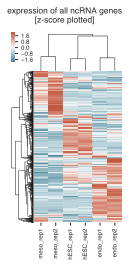

In [58]:
expr_ncRNA_heatmap = expr_gene_ncRNA[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
g = sns.clustermap(expr_ncRNA_heatmap, yticklabels=False, figsize=(2, 3.5), cmap=cmap, metric="correlation",
                   **{"rasterized": True}, linewidths=0.0, z_score=0)
#g.ax_row_dendrogram.set_visible(False)
plt.suptitle("expression of all ncRNA genes\n[z-score plotted]")
plt.savefig("Fig2A_1.pdf", bbox_inches="tight", dpi="figure")

In [59]:
expr_mRNA = expr_filt[(expr_filt["gene_biotype"] == "protein_coding") & (expr_filt["threshold"] == "expressed")]
print("there are %s protein-coding transcripts expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_mRNA)))

there are 102773 protein-coding transcripts expressed at at least 0.1 tpm in any of the 4 lineages


In [60]:
expr_gene_mRNA = expr_gene_filt[(expr_gene_filt["gene_biotype"] == "protein_coding") & (expr_gene_filt["threshold"] == "expressed")]
print("there are %s protein-coding genes expressed at at least 0.1 tpm in any of the 4 lineages" % (len(expr_gene_mRNA)))

there are 17332 protein-coding genes expressed at at least 0.1 tpm in any of the 4 lineages


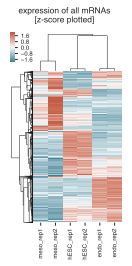

In [61]:
expr_mRNA_heatmap = expr_gene_mRNA.sort_values(by="overall_mean", ascending=False).head(10000)[["hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]]
sns.clustermap(expr_mRNA_heatmap, yticklabels=False, z_score=0, cmap=cmap, figsize=(2, 3.5), metric="correlation",
               **{"rasterized": True}, linewidths=0.0)
plt.suptitle("expression of all mRNAs\n[z-score plotted]")
plt.savefig("Fig2A_2.pdf", bbox_inches="tight")

### 7. plot expression of certain markers

In [62]:
marker_genes = ["POU5F1", "NANOG", "EOMES", "GATA6", "T"]
sub = expr_gene[expr_gene["gene_name"].isin(marker_genes)]
sub

gene_id gene_name             csf    gene_biotype  \
3937   ENSG00000111704.10_1     NANOG  protein_coding  protein_coding   
8120    ENSG00000141448.8_1     GATA6  protein_coding  protein_coding   
11048  ENSG00000163508.12_1     EOMES  protein_coding  protein_coding   
11381   ENSG00000164458.9_1         T  protein_coding  protein_coding   
20244  ENSG00000204531.16_2    POU5F1  protein_coding  protein_coding   

         hESC_rep1    hESC_rep2   endo_rep1   endo_rep2  meso_rep1  meso_rep2  \
3937     99.489067    96.265100    3.743922    3.954242   0.287930   0.247528   
8120      0.115014     0.013169  118.358165  121.961484   0.271290   0.160848   
11048     0.357119     0.105882  181.559596  192.001072   0.041182   0.033138   
11381     0.105423     0.057706    0.714125    0.961246  98.270098  89.096124   
20244  1833.962278  1760.956771   22.298885   23.138939  12.856123  17.725480   

         hESC_mean   hESC_std   endo_mean  endo_std  meso_mean  meso_std  \
3937     97.877084   2.279689    3.849082  0.148718   0.267729  0.028569   
8120      0.064092   0.072015  120.159824  2.547931   0.216069  0.078095   
11048     0.231500   0.177651  186.780334  7.383238   0.037160  0.005688   
11381     0.081565   0.033741    0.837686  0.174741  93.683111  6.486979   
20244  1797.459524  51.622689   22.718912  0.594008  15.290801  3.443155   

       overall_mean  threshold clean_gene_biotype cleaner_biotype  
3937      33.997965  expressed     protein_coding  protein_coding  
8120      40.146662  expressed     protein_coding  protein_coding  
11048     62.349665  expressed     protein_coding  protein_coding  
11381     31.534120  expressed     protein_coding  protein_coding  
20244    611.823079  expressed     protein_coding  protein_coding

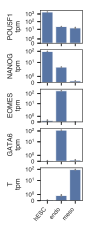

In [63]:
fig, axarr = plt.subplots(figsize=(0.75, 3.5), ncols=1,  nrows=5, sharex=True)

for i, gene in enumerate(marker_genes):
    sub = expr_gene[expr_gene["gene_name"] == gene][["gene_name", "hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2",
                                                     "meso_rep1", "meso_rep2"]]
    sub = pd.melt(sub, id_vars="gene_name")
    sub["sample"] = sub["variable"].str.split("_", expand=True)[0]
    sub["log_val"] = np.log10(sub["value"]+1)
    ax = axarr[i]
    sns.barplot(data=sub, x="sample", y="value", color=sns.color_palette("deep")[0], ax=ax, errwidth=1.5, ci=90,
                errcolor="gray")
    ax.set_yscale("symlog")
    
    ax.set_ylabel("%s\ntpm" % gene)
    ax.set_xlabel("")
    if i == 4:
        ax.set_xticklabels(["hESC", "endo", "meso"], rotation=50, va="top", ha="right")
        
fig.savefig("Fig2B.pdf", dpi="figure", bbox_inches="tight")

### 8. plot tissue specificity of lncRNAs vs mRNAs

In [64]:
all_ncRNA = expr_gene[expr_gene["csf"] != "protein_coding"]
all_mRNA = expr_gene[expr_gene["csf"] == "protein_coding"]

In [65]:
all_ncRNA_mean = all_ncRNA[["hESC_mean", "endo_mean", "meso_mean"]]
all_mRNA_mean = all_mRNA[["hESC_mean", "endo_mean", "meso_mean"]]

all_ncRNA_mean = all_ncRNA_mean + 1
all_mRNA_mean = all_mRNA_mean + 1

all_ncRNA_mean = np.log10(all_ncRNA_mean)
all_mRNA_mean = np.log10(all_mRNA_mean)

all_ncRNA_mean["gene_name"] = all_ncRNA["gene_name"]
all_mRNA_mean["gene_name"] = all_mRNA["gene_name"]

In [66]:
all_ncRNA_mean_array = all_ncRNA_mean.drop("gene_name", axis=1).as_matrix()
ncRNA_max = np.max(all_ncRNA_mean_array, axis=1)
tmp = all_ncRNA_mean_array.T / ncRNA_max
tmp = 1 - tmp.T
ncRNA_specs = np.sum(tmp, axis=1)/3
print(len(ncRNA_specs))
print(len(all_ncRNA))

40121
40121


In [67]:
all_mRNA_mean_array = all_mRNA_mean.drop("gene_name", axis=1).as_matrix()
mRNA_max = np.max(all_mRNA_mean_array, axis=1)
tmp = all_mRNA_mean_array.T / mRNA_max
tmp = 1 - tmp.T
mRNA_specs = np.sum(tmp, axis=1)/3
print(len(mRNA_specs))
print(len(all_mRNA))

20132
20132


In [68]:
# # randomly sample for cdf plotting
# ncRNA_specs_samp = np.random.choice(ncRNA_specs, size=50)
# mRNA_specs_samp = np.random.choice(mRNA_specs, size=50)

In [69]:
# remove transcripts with all 0 expression values (these have tissue spec of NA)
mRNA_specs_nonan = mRNA_specs[~np.isnan(mRNA_specs)]
ncRNA_specs_nonan = ncRNA_specs[~np.isnan(ncRNA_specs)]

print(len(mRNA_specs_nonan))
print(len(ncRNA_specs_nonan))

19208
27502


In [70]:
all_ncRNA_mean["tissue_spec"] = ncRNA_specs
all_ncRNA_mean["type"] = "lncRNA"

all_mRNA_mean["tissue_spec"] = mRNA_specs
all_mRNA_mean["type"] = "mRNA"

tissue_spec = all_ncRNA_mean.append(all_mRNA_mean)
tissue_spec.sample(5)

hESC_mean  endo_mean  meso_mean      gene_name  tissue_spec    type
56580   0.199377   0.152406   0.000000  RP11-136C24.3     0.411863    mRNA
14616   1.364792   1.393181   1.094213        DPY19L3     0.078324    mRNA
24810   0.437499   0.590297   0.459373     AC010297.1     0.160214  lncRNA
54769   0.000000   0.000000   0.000000  RP11-111N20.4          NaN  lncRNA
28914   0.014727   0.000000   0.000000        ISCA1P6     0.666667  lncRNA

In [71]:
# compare lncRNAs to TFs
tfs = pd.read_table(tfs_f)
print(len(tfs.gene_name.unique()))
tfs.head()

927


index          gene_id gene_name
0      HKR1  ENSG00000181666      HKR1
1  M00117_1  ENSG00000137203    TFAP2A
2  M00118_1  ENSG00000137203    TFAP2A
3  M00119_1  ENSG00000137203    TFAP2A
4  M00120_1  ENSG00000137203    TFAP2A

In [72]:
tfs_spec = tissue_spec[tissue_spec["gene_name"].isin(tfs["gene_name"])]["tissue_spec"]
len(tfs_spec)

926

In [73]:
tf_specs_nonan = tfs_spec[~np.isnan(tfs_spec)]
len(tf_specs_nonan)

916

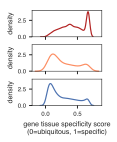

In [74]:
fig, axarr = plt.subplots(figsize=(1.25,1.75), nrows=3, ncols=1, sharex=True, sharey=True)

ax = axarr[0]
sns.distplot(ncRNA_specs_nonan, label="lncRNAs", color="firebrick", 
             hist=False, kde_kws=dict(cumulative=False), ax=ax)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("density")

ax = axarr[1]
sns.distplot(tf_specs_nonan, label="transcription factors", color=sns.color_palette("Set2")[1],
             hist=False, kde_kws=dict(cumulative=False), ax=ax)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("density")

ax = axarr[2]
sns.distplot(mRNA_specs_nonan, label="protein-coding genes", 
             hist=False, kde_kws=dict(cumulative=False), ax=ax)
ax.get_legend().remove()
ax.set_xlabel("gene tissue specificity score\n(0=ubiquitous, 1=specific)")
ax.set_ylabel("density")

fig.subplots_adjust(hspace=0.3)
fig.savefig("Fig2F.pdf", bbox_inches="tight", dpi="figure")

### 9. GO plots

In [75]:
endo_go_f = "../../misc/02__GO_enrichments/endo_enriched.txt"
endo_go = pd.read_table(endo_go_f, skiprows=7)
endo_go.head()

GO biological process complete  \
0               endoderm formation (GO:0001706)   
1  endodermal cell differentiation (GO:0035987)   
2             endoderm development (GO:0007492)   
3  formation of primary germ layer (GO:0001704)   
4                     gastrulation (GO:0007369)   

   Homo sapiens - REFLIST (20996)  upload_1 (1852)  upload_1 (expected)  \
0                              47               22                 4.15   
1                              41               19                 3.62   
2                              72               28                 6.35   
3                             111               33                 9.79   
4                             155               44                13.67   

  upload_1 (over/under)  upload_1 (fold Enrichment)  upload_1 (P-value)  
0                     +                        5.31            0.000108  
1                     +                        5.25            0.001200  
2                     +                        4.41            0.000032  
3                     +                        3.37            0.000321  
4                     +                        3.22            0.000006

In [76]:
endo_go["neg_p"] = -np.log10(endo_go["upload_1 (P-value)"])
endo_go["process"] = endo_go["GO biological process complete"].str.split(' \\(', expand=True)[0]
endo_go.head()

GO biological process complete  \
0               endoderm formation (GO:0001706)   
1  endodermal cell differentiation (GO:0035987)   
2             endoderm development (GO:0007492)   
3  formation of primary germ layer (GO:0001704)   
4                     gastrulation (GO:0007369)   

   Homo sapiens - REFLIST (20996)  upload_1 (1852)  upload_1 (expected)  \
0                              47               22                 4.15   
1                              41               19                 3.62   
2                              72               28                 6.35   
3                             111               33                 9.79   
4                             155               44                13.67   

  upload_1 (over/under)  upload_1 (fold Enrichment)  upload_1 (P-value)  \
0                     +                        5.31            0.000108   
1                     +                        5.25            0.001200   
2                     +                        4.41            0.000032   
3                     +                        3.37            0.000321   
4                     +                        3.22            0.000006   

      neg_p                          process  
0  3.966576               endoderm formation  
1  2.920819  endodermal cell differentiation  
2  4.497573             endoderm development  
3  3.493495  formation of primary germ layer  
4  5.211832                     gastrulation

In [77]:
meso_go_f = "../../misc/02__GO_enrichments/meso_enriched.txt"
meso_go = pd.read_table(meso_go_f, skiprows=7)
meso_go.head()

GO biological process complete  \
0                hindlimb morphogenesis (GO:0035137)   
1  anterior/posterior pattern specification (GO:0...   
2  embryonic skeletal system development (GO:0048...   
3                         somitogenesis (GO:0001756)   
4  embryonic skeletal system morphogenesis (GO:00...   

   Homo sapiens - REFLIST (20996)  upload_1 (1482)  upload_1 (expected)  \
0                              36               16                 2.54   
1                             209               68                14.75   
2                             128               39                 9.03   
3                              69               21                 4.87   
4                              96               29                 6.78   

  upload_1 (over/under)  upload_1 (fold Enrichment)  upload_1 (P-value)  
0                     +                        6.30        1.110000e-03  
1                     +                        4.61        9.010000e-18  
2                     +                        4.32        2.330000e-08  
3                     +                        4.31        2.540000e-03  
4                     +                        4.28        1.700000e-05

In [78]:
meso_go["neg_p"] = -np.log10(meso_go["upload_1 (P-value)"])
meso_go["process"] = meso_go["GO biological process complete"].str.split(' \\(', expand=True)[0]
meso_go.head()

GO biological process complete  \
0                hindlimb morphogenesis (GO:0035137)   
1  anterior/posterior pattern specification (GO:0...   
2  embryonic skeletal system development (GO:0048...   
3                         somitogenesis (GO:0001756)   
4  embryonic skeletal system morphogenesis (GO:00...   

   Homo sapiens - REFLIST (20996)  upload_1 (1482)  upload_1 (expected)  \
0                              36               16                 2.54   
1                             209               68                14.75   
2                             128               39                 9.03   
3                              69               21                 4.87   
4                              96               29                 6.78   

  upload_1 (over/under)  upload_1 (fold Enrichment)  upload_1 (P-value)  \
0                     +                        6.30        1.110000e-03   
1                     +                        4.61        9.010000e-18   
2                     +                        4.32        2.330000e-08   
3                     +                        4.31        2.540000e-03   
4                     +                        4.28        1.700000e-05   

       neg_p                                   process  
0   2.954677                    hindlimb morphogenesis  
1  17.045275  anterior/posterior pattern specification  
2   7.632644     embryonic skeletal system development  
3   2.595166                             somitogenesis  
4   4.769551   embryonic skeletal system morphogenesis

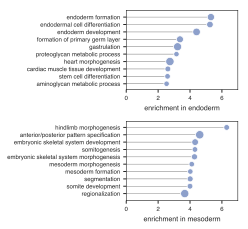

In [79]:
fig, axarr = plt.subplots(figsize=(2, 3.5), ncols=1, nrows=2, sharex=False)
labels = ["endoderm", "mesoderm"]
for i, df in enumerate([endo_go, meso_go]):
    label = labels[i]
    ax = axarr[i]
    
    sub = df.sort_values(by="upload_1 (fold Enrichment)", ascending=False).head(10)
    sub["ytick"] = list(range(len(sub)))[::-1]
    
    for i, row in sub.iterrows():
        xmax = row["upload_1 (fold Enrichment)"]
        y = row.ytick
        ax.plot([0, xmax], [y, y], color="gray", linewidth=0.5)
    
    sns.scatterplot(data=sub, x="upload_1 (fold Enrichment)", y="ytick", size="neg_p", ax=ax, legend=False,
                    color=sns.color_palette("Set2")[2], sizes=(30, 70), zorder=10)
    
    ax.set_yticks(np.arange(len(sub)))
    ax.set_yticklabels(sub["process"][::-1])
    ax.set_ylabel("")
    ax.set_xlim((0, 7))
    
    ax.set_xlabel("enrichment in %s" % label)

fig.subplots_adjust(hspace=0.4)
fig.savefig("Fig2C.pdf", dpi="figure", bbox_inches="tight")

### 8. find differentially expressed transcripts

In [80]:
diff_hESC_endo = pd.read_table(diff_hESC_endo_f, sep="\t")
diff_hESC_meso = pd.read_table(diff_hESC_meso_f, sep="\t")

In [81]:
diff_hESC_endo.fillna("sleuth NA", inplace=True)
diff_hESC_meso.fillna("sleuth NA", inplace=True)

In [82]:
diff = diff_hESC_endo.merge(diff_hESC_meso, on="target_id", how="outer", suffixes=("_hESC_endo", "_hESC_meso"))
diff.head()

target_id pval_hESC_endo qval_hESC_endo test_stat_hESC_endo  \
0  ENST00000344616.3_1    1.07775e-07    0.000294335             28.2291   
1  ENST00000367033.3_1    6.77329e-08    0.000294335             29.1285   
2  ENST00000272134.5_1    1.34886e-08    0.000294335             32.2596   
3  ENST00000374866.7_1    3.69263e-08    0.000294335             30.3045   
4  ENST00000309955.7_1    1.24716e-07    0.000294335             27.9465   

  rss_hESC_endo degrees_free_hESC_endo mean_obs_hESC_endo var_obs_hESC_endo  \
0       23.6363                      1            7.71458           7.87876   
1       17.2829                      1            8.06591           5.76096   
2       35.0995                      1            9.11269           11.6998   
3       10.2905                      1            10.1222           3.43016   
4        7.2004                      1             8.3565           2.40013   

  tech_var_hESC_endo sigma_sq_hESC_endo           ...             \
0         0.00431347            7.87445           ...              
1         0.00129888            5.75966           ...              
2        0.000983585            11.6989           ...              
3        8.51721e-05            3.43008           ...              
4        0.000482128            2.39965           ...              

  qval_hESC_meso test_stat_hESC_meso rss_hESC_meso degrees_free_hESC_meso  \
0      0.0045401             15.3708       34.5904                      1   
1     0.00402961             16.0858       8.61227                      1   
2      0.0512481             5.68945       17.1537                      1   
3              1           -0.525238       0.98023                      1   
4      0.0604654             5.04753      0.201606                      1   

  mean_obs_hESC_meso var_obs_hESC_meso tech_var_hESC_meso sigma_sq_hESC_meso  \
0            2.24747           11.5301         0.00428367            11.5259   
1            7.34726           2.87076         0.00139058            2.86937   
2            4.20944            5.7179           0.211507            5.50639   
3            8.34522          0.326743         0.00370644           0.323037   
4            7.08501          0.067202        0.000898444          0.0663035   

  smooth_sigma_sq_hESC_meso final_sigma_sq_hESC_meso  
0                   1.61297                  11.5259  
1                  0.188002                  2.86937  
2                  0.506161                  5.50639  
3                  0.139786                 0.323037  
4                  0.205194                 0.205194  

[5 rows x 23 columns]

In [83]:
diff[diff["target_id"] == "DIGIT"]

target_id pval_hESC_endo qval_hESC_endo test_stat_hESC_endo  \
12690     DIGIT    0.000959115     0.00816853             10.9049   

      rss_hESC_endo degrees_free_hESC_endo mean_obs_hESC_endo  \
12690       39.9892                      1            3.43597   

      var_obs_hESC_endo tech_var_hESC_endo sigma_sq_hESC_endo  \
12690           13.3297          0.0814267            13.2483   

                ...            qval_hESC_meso test_stat_hESC_meso  \
12690           ...                 sleuth NA           sleuth NA   

      rss_hESC_meso degrees_free_hESC_meso mean_obs_hESC_meso  \
12690     sleuth NA              sleuth NA          sleuth NA   

      var_obs_hESC_meso tech_var_hESC_meso sigma_sq_hESC_meso  \
12690         sleuth NA          sleuth NA          sleuth NA   

      smooth_sigma_sq_hESC_meso final_sigma_sq_hESC_meso  
12690                 sleuth NA                sleuth NA  

[1 rows x 23 columns]

In [84]:
diff["hESC_vs_endo"] = diff.apply(is_significant, colname="qval_hESC_endo", alpha=0.05, axis=1)
diff["hESC_vs_meso"] = diff.apply(is_significant, colname="qval_hESC_meso", alpha=0.05, axis=1)
diff.sample(5)

target_id pval_hESC_endo qval_hESC_endo test_stat_hESC_endo  \
6635    ENST00000275053.8_1     0.00019615     0.00319461             13.8676   
150583  ENST00000437011.1_1      sleuth NA      sleuth NA           sleuth NA   
77741   ENST00000373395.3_1       0.155767        0.21655             2.01484   
90766   ENST00000625841.1_1       0.253748       0.302142             1.30255   
42919   ENST00000593345.1_1      0.0272339      0.0685797             4.87592   

       rss_hESC_endo degrees_free_hESC_endo mean_obs_hESC_endo  \
6635        0.468467                      1            7.13755   
150583     sleuth NA              sleuth NA          sleuth NA   
77741       0.300828                      1            2.18476   
90766        1.08713                      1             1.7129   
42919       0.217516                      1             3.8709   

       var_obs_hESC_endo tech_var_hESC_endo sigma_sq_hESC_endo  \
6635            0.156156         0.00150386           0.154652   
150583         sleuth NA          sleuth NA          sleuth NA   
77741           0.100276           0.118012         -0.0177363   
90766           0.362376           0.426713         -0.0643373   
42919          0.0725053          0.0244486          0.0480567   

             ...        rss_hESC_meso degrees_free_hESC_meso  \
6635         ...            0.0461069                      1   
150583       ...            sleuth NA              sleuth NA   
77741        ...             0.391683                      1   
90766        ...            sleuth NA              sleuth NA   
42919        ...             0.344451                      1   

       mean_obs_hESC_meso var_obs_hESC_meso tech_var_hESC_meso  \
6635              7.46173          0.015369        0.000714541   
150583          sleuth NA         sleuth NA          sleuth NA   
77741             2.25497          0.130561           0.114752   
90766           sleuth NA         sleuth NA          sleuth NA   
42919             3.83009          0.114817          0.0223918   

       sigma_sq_hESC_meso smooth_sigma_sq_hESC_meso final_sigma_sq_hESC_meso  \
6635            0.0146544                  0.181168                 0.181168   
150583          sleuth NA                 sleuth NA                sleuth NA   
77741           0.0158087                   1.60659                  1.60659   
90766           sleuth NA                 sleuth NA                sleuth NA   
42919           0.0924253                  0.601407                 0.601407   

           hESC_vs_endo     hESC_vs_meso  
6635        significant      significant  
150583        sleuth NA        sleuth NA  
77741   not significant  not significant  
90766   not significant        sleuth NA  
42919   not significant  not significant  

[5 rows x 25 columns]

In [85]:
expr_diff = expr.merge(diff, left_on="transcript_id", right_on="target_id", how="inner")
expr_diff["endo_pseudo"] = expr_diff["endo_mean"] + 1
expr_diff["hESC_pseudo"] = expr_diff["hESC_mean"] + 1
expr_diff["meso_pseudo"] = expr_diff["meso_mean"] + 1
expr_diff["endo_hESC_log2fc"] = np.log2(expr_diff["endo_pseudo"]/expr_diff["hESC_pseudo"])
expr_diff["meso_hESC_log2fc"] = np.log2(expr_diff["meso_pseudo"]/expr_diff["hESC_pseudo"])
expr_diff["endo_hESC_log2fc_abs"] = np.abs(expr_diff["endo_hESC_log2fc"])
expr_diff["meso_hESC_log2fc_abs"] = np.abs(expr_diff["meso_hESC_log2fc"])
expr_diff.sample(5)

transcript_id               gene_id      gene_name  \
58368   ENST00000439235.5_1  ENSG00000170004.16_2           CHD3   
169301  ENST00000584156.5_1  ENSG00000150636.16_2       CCDC102B   
197619  ENST00000634543.1_1   ENSG00000282860.1_1  RP11-153F10.2   
94377   ENST00000487654.5_1  ENSG00000117448.13_2         AKR1A1   
12682   ENST00000334268.8_1  ENSG00000186439.12_2           TRDN   

                    csf transcript_biotype    gene_biotype  hESC_rep1  \
58368    protein_coding     protein_coding  protein_coding   0.411906   
169301   protein_coding     protein_coding  protein_coding   0.000000   
197619  lncRNA_good_csf         intergenic      intergenic   0.057442   
94377    protein_coding     protein_coding  protein_coding   0.550075   
12682    protein_coding     protein_coding  protein_coding   1.353748   

        hESC_rep2  endo_rep1  endo_rep2         ...           \
58368    0.526659   2.201829   2.793711         ...            
169301   0.031794   0.748993   0.705785         ...            
197619   0.029062   0.074633   0.110371         ...            
94377    0.115789   0.135049   0.269380         ...            
12682    1.359589  11.562342  12.394631         ...            

        final_sigma_sq_hESC_meso     hESC_vs_endo     hESC_vs_meso  \
58368                    2.33746      significant      significant   
169301                 sleuth NA      significant        sleuth NA   
197619                 sleuth NA        sleuth NA        sleuth NA   
94377                     1.3589  not significant  not significant   
12682                    2.01438      significant      significant   

        endo_pseudo  hESC_pseudo  meso_pseudo  endo_hESC_log2fc  \
58368      3.497770     1.469282     5.978202          1.251324   
169301     1.727389     1.015897     1.049004          0.765839   
197619     1.092502     1.043252     1.158305          0.066548   
94377      1.202215     1.332932     2.633325         -0.148909   
12682     12.978486     2.356668     1.092757          2.461302   

        meso_hESC_log2fc  endo_hESC_log2fc_abs meso_hESC_log2fc_abs  
58368           2.024600              1.251324             2.024600  
169301          0.046266              0.765839             0.046266  
197619          0.150927              0.066548             0.150927  
94377           0.982282              0.148909             0.982282  
12682          -1.108776              2.461302             1.108776  

[5 rows x 56 columns]

In [86]:
sig_hESC_endo = expr_diff[(expr_diff["hESC_vs_endo"] == "significant")]
sig_hESC_meso = expr_diff[(expr_diff["hESC_vs_meso"] == "significant")]

print("# of significantly differentially expressed transcripts b/w hESC and endo: %s" % (len(sig_hESC_endo)))
print("# of significantly differentially expressed transcripts b/w hESC and meso: %s" % (len(sig_hESC_meso)))

# of significantly differentially expressed transcripts b/w hESC and endo: 37390
# of significantly differentially expressed transcripts b/w hESC and meso: 33841


In [87]:
print("# of significantly differentially expressed genes with b/w hESC and endo: %s" % (len(sig_hESC_endo.gene_name.unique())))
print("# of significantly differentially expressed genes with b/w hESC and meso: %s" % (len(sig_hESC_meso.gene_name.unique())))

# of significantly differentially expressed genes with b/w hESC and endo: 17318
# of significantly differentially expressed genes with b/w hESC and meso: 16042


In [88]:
sig_hESC_endo_ncRNA = sig_hESC_endo[sig_hESC_endo["gene_name"].isin(expr_ncRNA["gene_name"])]
sig_hESC_meso_ncRNA = sig_hESC_meso[sig_hESC_meso["gene_name"].isin(expr_ncRNA["gene_name"])]

In [89]:
print("# of significantly differentially expressed ncRNA transcripts b/w hESC and endo: %s" % (len(sig_hESC_endo_ncRNA)))
print("# of significantly differentially expressed ncRNA transcripts b/w hESC and meso: %s" % (len(sig_hESC_meso_ncRNA)))

# of significantly differentially expressed ncRNA transcripts b/w hESC and endo: 2890
# of significantly differentially expressed ncRNA transcripts b/w hESC and meso: 2487


In [90]:
print("# of significantly differentially expressed ncRNA transcripts b/w hESC and endo: %s" % (len(sig_hESC_endo_ncRNA.gene_name.unique())))
print("# of significantly differentially expressed ncRNA transcripts b/w hESC and meso: %s" % (len(sig_hESC_meso_ncRNA.gene_name.unique())))

# of significantly differentially expressed ncRNA transcripts b/w hESC and endo: 2117
# of significantly differentially expressed ncRNA transcripts b/w hESC and meso: 1868


In [91]:
sig_2fc_hESC_endo = expr_diff[(expr_diff["hESC_vs_endo"] == "significant") & 
                              (expr_diff["endo_hESC_log2fc_abs"] > 1)]
sig_2fc_hESC_meso = expr_diff[(expr_diff["hESC_vs_meso"] == "significant") & 
                              (expr_diff["meso_hESC_log2fc_abs"] > 1)]

print("# of significantly differentially expressed transcripts with >2 foldchange b/w hESC and endo: %s" % (len(sig_2fc_hESC_endo)))
print("# of significantly differentially expressed transcripts with >2 foldchange b/w hESC and meso: %s" % (len(sig_2fc_hESC_meso)))

# of significantly differentially expressed transcripts with >2 foldchange b/w hESC and endo: 11794
# of significantly differentially expressed transcripts with >2 foldchange b/w hESC and meso: 16858


In [92]:
print("# of significantly differentially expressed genes with >2 foldchange b/w hESC and endo: %s" % (len(sig_2fc_hESC_endo.gene_name.unique())))
print("# of significantly differentially expressed genes with >2 foldchange b/w hESC and meso: %s" % (len(sig_2fc_hESC_meso.gene_name.unique())))

# of significantly differentially expressed genes with >2 foldchange b/w hESC and endo: 6601
# of significantly differentially expressed genes with >2 foldchange b/w hESC and meso: 9650


In [93]:
sig_2fc_hESC_endo_ncRNA = sig_2fc_hESC_endo[sig_2fc_hESC_endo["gene_name"].isin(expr_ncRNA["gene_name"])]
sig_2fc_hESC_meso_ncRNA = sig_2fc_hESC_meso[sig_2fc_hESC_meso["gene_name"].isin(expr_ncRNA["gene_name"])]

In [94]:
print("# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and endo: %s" % (len(sig_2fc_hESC_endo_ncRNA)))
print("# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and meso: %s" % (len(sig_2fc_hESC_meso_ncRNA)))

# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and endo: 1087
# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and meso: 1229


In [95]:
print("# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and endo: %s" % (len(sig_2fc_hESC_endo_ncRNA.gene_name.unique())))
print("# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and meso: %s" % (len(sig_2fc_hESC_meso_ncRNA.gene_name.unique())))

# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and endo: 780
# of significantly differentially expressed ncRNA transcripts with >2 foldchange b/w hESC and meso: 934


## 9. volcano plots

In [96]:
diff_hESC_endo = expr_diff[expr_diff["qval_hESC_endo"] != "sleuth NA"]
diff_hESC_meso = expr_diff[expr_diff["qval_hESC_meso"] != "sleuth NA"]
diff_hESC_endo["qval_log10_hESC_endo"] = -np.log10(diff_hESC_endo["qval_hESC_endo"].astype(float))
diff_hESC_meso["qval_log10_hESC_meso"] = -np.log10(diff_hESC_meso["qval_hESC_meso"].astype(float))

In [97]:
diff_hESC_endo["hESC_vs_endo_log"] = diff_hESC_endo.apply(mark_for_volcano, exp_col="endo_hESC_log2fc_abs", sig_col="hESC_vs_endo", axis=1)
diff_hESC_meso["hESC_vs_meso_log"] = diff_hESC_meso.apply(mark_for_volcano, exp_col="meso_hESC_log2fc_abs", sig_col="hESC_vs_meso", axis=1)

In [98]:
diff_hESC_endo_ncRNA = diff_hESC_endo[diff_hESC_endo["gene_name"].isin(expr_ncRNA["gene_name"])]
diff_hESC_meso_ncRNA = diff_hESC_meso[diff_hESC_meso["gene_name"].isin(expr_ncRNA["gene_name"])]

In [99]:
diff_hESC_endo_ncRNA.hESC_vs_endo_log.value_counts()

not significant    6606
significant        2890
Name: hESC_vs_endo_log, dtype: int64

In [100]:
diff_hESC_meso_ncRNA.hESC_vs_meso_log.value_counts()

not significant    6906
significant        2487
Name: hESC_vs_meso_log, dtype: int64

In [101]:
len(diff_hESC_endo_ncRNA[diff_hESC_endo_ncRNA["qval_hESC_endo"] < 0.05])

2890

In [102]:
len(diff_hESC_endo_ncRNA[diff_hESC_endo_ncRNA["qval_hESC_endo"] < 0.05]["gene_name"].unique())

2117

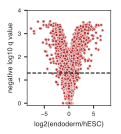

In [103]:
fig = plt.figure(figsize=(1.5, 1.75))
g = sns.regplot(x="endo_hESC_log2fc", y="qval_log10_hESC_endo", data=diff_hESC_endo_ncRNA, fit_reg=False, 
               color="firebrick", scatter_kws={"s": 8, "edgecolors": "white", "linewidths": 0.5})

plt.xlabel("log2(endoderm/hESC)")
plt.ylabel("negative log10 q value")
plt.ylim((-0.1, 4))
plt.xlim((-8.5, 8.5))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
#plt.title("volcano plot for ncRNAs in endoderm vs. hESCs\n(n=%s)" % (len(diff_hESC_endo_ncRNA)))
plt.savefig("Fig2E_1.pdf", bbox_inches="tight", dpi="figure")

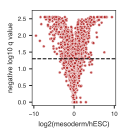

In [104]:
fig = plt.figure(figsize=(1.5, 1.75))
g = sns.regplot(x="meso_hESC_log2fc", y="qval_log10_hESC_meso", data=diff_hESC_meso_ncRNA, fit_reg=False, 
               color="firebrick", scatter_kws={"s": 8, "edgecolors": "white", "linewidths": 0.5})

plt.xlabel("log2(mesoderm/hESC)")
plt.ylabel("negative log10 q value")
plt.ylim((-0.1, 2.75))
#plt.xlim((-8.5, 8.5))
plt.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=1)
#plt.title("volcano plot for ncRNAs in endoderm vs. hESCs\n(n=%s)" % (len(diff_hESC_endo_ncRNA)))
plt.savefig("Fig2E_2.pdf", bbox_inches="tight", dpi="figure")

In [105]:
len(diff_hESC_meso_ncRNA[diff_hESC_meso_ncRNA["qval_hESC_meso"] < 0.05])

2487

In [106]:
len(diff_hESC_meso_ncRNA[diff_hESC_meso_ncRNA["qval_hESC_meso"] < 0.05]["gene_name"].unique())

1868

In [107]:
meso_tx = list(diff_hESC_meso_ncRNA[diff_hESC_meso_ncRNA["qval_hESC_meso"] < 0.05]["transcript_id"])
endo_tx = list(diff_hESC_endo_ncRNA[diff_hESC_endo_ncRNA["qval_hESC_endo"] < 0.05]["transcript_id"])
tot_tx = meso_tx + endo_tx
tot_tx = set(tot_tx)
len(tot_tx)

4158

In [108]:
len(set(meso_tx).intersection(set(endo_tx)))

1219

In [109]:
meso_g = list(diff_hESC_meso_ncRNA[diff_hESC_meso_ncRNA["qval_hESC_meso"] < 0.05]["gene_name"])
endo_g = list(diff_hESC_endo_ncRNA[diff_hESC_endo_ncRNA["qval_hESC_endo"] < 0.05]["gene_name"])
tot_g = meso_g + endo_g
tot_g = set(tot_g)
len(tot_g)

2961

In [110]:
len(set(meso_g).intersection(set(endo_g)))

1024

## 12. write final gene list file

In [111]:
final = expr[["transcript_id", "gene_id", "gene_name", "csf", "cleaner_gene_biotype", 
              "cleaner_transcript_biotype", "hESC_rep1",
              "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2",
              "hESC_mean", "endo_mean", "meso_mean", "overall_mean", "threshold"]]
final = final.merge(expr_diff[["transcript_id", "gene_id", "gene_name", "csf", 
                               "cleaner_gene_biotype", "cleaner_transcript_biotype", "qval_hESC_endo", 
                               "qval_hESC_meso", "endo_hESC_log2fc", 
                               "meso_hESC_log2fc"]], 
                    on=["transcript_id", "gene_id", "gene_name", "csf", "cleaner_gene_biotype",
                        "cleaner_transcript_biotype"],
                    how="left")
final = final[final["transcript_id"].isin(expr_filt["transcript_id"])]
final.fillna("filter not met", inplace=True)
final.head()

transcript_id               gene_id gene_name              csf  \
0                 DIGIT                 DIGIT     DIGIT  lncRNA_good_csf   
1   ENST00000000233.9_1  ENSG00000004059.10_2      ARF5   protein_coding   
2     ENST00000000412.3     ENSG00000003056.3      M6PR   protein_coding   
3  ENST00000000442.10_1  ENSG00000173153.13_2     ESRRA   protein_coding   
4   ENST00000001008.5_1   ENSG00000004478.7_1     FKBP4   protein_coding   

  cleaner_gene_biotype cleaner_transcript_biotype   hESC_rep1   hESC_rep2  \
0     promoter_overlap           promoter_overlap    0.000000    0.025422   
1       protein_coding             protein_coding  101.476958  102.386195   
2       protein_coding             protein_coding   49.696030   46.457026   
3       protein_coding             protein_coding    1.924618    3.493033   
4       protein_coding             protein_coding   71.840722   79.489420   

    endo_rep1   endo_rep2        ...          meso_rep2   hESC_mean  \
0    4.907468    4.784695        ...           0.014741    0.012711   
1  222.677573  197.586091        ...         245.318970  101.931577   
2   31.608496   36.350968        ...          10.951882   48.076528   
3    3.499700    2.419880        ...           7.769760    2.708826   
4   33.770398   33.810736        ...          68.012268   75.665071   

    endo_mean   meso_mean  overall_mean  threshold qval_hESC_endo  \
0    4.846082    0.007370      1.622054  expressed     0.00816853   
1  210.131832  204.374142    172.145850  expressed     0.00578744   
2   33.979732   20.552771     34.203010  expressed     0.00549724   
3    2.959790    7.600094      4.422903  expressed       0.814912   
4   33.790567   61.985019     57.146886  expressed     0.00160854   

  qval_hESC_meso endo_hESC_log2fc  meso_hESC_log2fc  
0      sleuth NA         2.529248         -0.007628  
1      0.0346694         1.036458          0.996569  
2       0.138947        -0.488514         -1.187160  
3      0.0241643         0.094461          1.213390  
4      0.0935556        -1.139873         -0.283561  

[5 rows x 21 columns]

In [112]:
len(final)

170623

In [113]:
final.columns

Index(['transcript_id', 'gene_id', 'gene_name', 'csf', 'cleaner_gene_biotype',
       'cleaner_transcript_biotype', 'hESC_rep1', 'hESC_rep2', 'endo_rep1',
       'endo_rep2', 'meso_rep1', 'meso_rep2', 'hESC_mean', 'endo_mean',
       'meso_mean', 'overall_mean', 'threshold', 'qval_hESC_endo',
       'qval_hESC_meso', 'endo_hESC_log2fc', 'meso_hESC_log2fc'],
      dtype='object')

In [114]:
f = "../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [115]:
final.to_csv(f, sep="\t", index=False)

## 13. write supplemental table -- lncRNA RNA-seq results

In [116]:
supp = final[final["csf"] == "lncRNA_good_csf"]
len(supp)

25107

In [117]:
supp["abs_l2fc"] = np.abs(supp["endo_hESC_log2fc"])
supp = supp.sort_values(by="abs_l2fc", ascending=False)

In [118]:
supp = supp[["gene_name", "gene_id", "transcript_id", "cleaner_transcript_biotype",
             "hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2", "threshold",
             "endo_hESC_log2fc", "qval_hESC_endo", "meso_hESC_log2fc", "qval_hESC_meso"]]

In [119]:
supp.columns = ["gene_name", "gene_id", "transcript_id", "biotype", "hESC_rep1_tpm", "hESC_rep2_tpm",
                "endo_rep1_tpm", "endo_rep2_tpm", "meso_rep1_tpm", "meso_rep2_tpm", "meets_threshold",
                "endo_hESC_log2fc", "endo_hESC_padj", "meso_hESC_log2fc", "meso_hESC_padj"]
supp.head()

gene_name              gene_id        transcript_id  \
126462      LINC00678  ENSG00000254934.5_1  ENST00000527083.5_1   
51934    RP11-132A1.3  ENSG00000232301.1_1  ENST00000429254.1_1   
50086       FOXD3-AS1  ENSG00000230798.5_1  ENST00000426393.5_1   
144799  RP11-511B23.1  ENSG00000257345.2_1  ENST00000552353.2_1   
105813      LINC01612  ENSG00000250266.1_1  ENST00000504509.1_1   

                   biotype  hESC_rep1_tpm  hESC_rep2_tpm  endo_rep1_tpm  \
126462  transcript_overlap     337.789719     296.181132       0.663297   
51934           intergenic     203.749549     175.002615       0.477245   
50086           intergenic     133.450489     128.128256       0.000000   
144799  transcript_overlap       0.227226       0.106531     137.625570   
105813          intergenic       1.114054       1.460213     217.482203   

        endo_rep2_tpm  meso_rep1_tpm  meso_rep2_tpm meets_threshold  \
126462       0.388375       0.042845       0.196287       expressed   
51934        0.249251       0.185868       0.225418       expressed   
50086        0.000000       0.043738       0.061261       expressed   
144799     124.607164       0.056430       0.061432       expressed   
105813     210.827192       0.526485       0.235386       expressed   

        endo_hESC_log2fc endo_hESC_padj  meso_hESC_log2fc meso_hESC_padj  
126462         -7.703217     0.00060438         -8.149877     0.00459268  
51934          -7.125660    0.000790556         -7.302906     0.00282409  
50086          -7.042090    0.000980578         -6.968271     0.00331203  
144799          6.823011    0.000723821         -0.140045      0.0891074  
105813          6.555690    0.000423398         -0.727895      0.0715698

In [120]:
f = "../../data/00__rna_seq/01__processed_results/SuppTable.RNA_seq.txt"
supp.to_csv(f, sep="\t", index=False)